# Exploratory Data Analysis

This notebook focuses on understanding the transaction dataset before modeling. We'll:
- Load and inspect the raw data
- Validate data quality (timestamps, missing values, duplicates)
- Analyze basic distributions
- Generate required descriptive plots
- Document key observations for modeling decisions

In [ ]:
# Core imports (import these first for faster startup)
import pandas as pd
import numpy as np
from datetime import datetime
import sys
from pathlib import Path

# Setup: Add project root to Python path for imports
# (Notebooks run from notebooks/ directory, so we need to add parent to path)
PROJECT_ROOT = Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Import project configuration (paths and constants)
from src.config import (
    PROJECT_ROOT,
    DATA_RAW,
    DATA_PROCESSED,
    FIGURES_DIR,
    OUTPUTS_DIR,
    ensure_directories
)

# Ensure all directories exist
ensure_directories()

# Use config paths (aliased for backward compatibility in notebook)
OUTPUTS = OUTPUTS_DIR
FIGURES = FIGURES_DIR

print("✓ Core imports loaded")
print(f"✓ Project root: {PROJECT_ROOT}")
print(f"✓ Data raw directory: {DATA_RAW}")
print(f"✓ Data processed directory: {DATA_PROCESSED}")
print(f"✓ Outputs directory: {OUTPUTS_DIR}")
print(f"✓ Figures directory: {FIGURES_DIR}")

✓ Core imports loaded
✓ Project root: /mnt/c/Users/zaido/OneDrive/Bureau/Quod_THA
✓ Data raw directory: /mnt/c/Users/zaido/OneDrive/Bureau/Quod_THA/data/raw
✓ Data processed directory: /mnt/c/Users/zaido/OneDrive/Bureau/Quod_THA/data/processed
✓ Outputs directory: /mnt/c/Users/zaido/OneDrive/Bureau/Quod_THA/outputs
✓ Figures directory: /mnt/c/Users/zaido/OneDrive/Bureau/Quod_THA/outputs/figures


In [75]:
# Matplotlib setup (load separately to avoid slowing down initial imports)
import matplotlib.pyplot as plt
%matplotlib inline

# Set plotting style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    # Fallback for older matplotlib versions
    plt.style.use('seaborn-darkgrid')

print("✓ Matplotlib configured")

✓ Matplotlib configured


## 1. Data Loading

Load and combine the raw transaction files. Data cleaning (duplicate removal, product name consolidation, date conversion) is handled by `src.data.load_and_process_transactions()`, which saves cleaned data to `data/processed/` for reuse.

In [79]:
# Import data loading function from src
from src.data import load_and_process_transactions

# Load and process transactions (will save to data/processed if not already processed)
# Uses paths from config.py by default
df = load_and_process_transactions(
    force_reprocess=False  # Set to True to force reprocessing
)

print(f"\nLoaded cleaned data:")
print(f"Total rows: {len(df):,}")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
df.head()

Loading processed data from /mnt/c/Users/zaido/OneDrive/Bureau/Quod_THA/data/processed/transactions_cleaned.csv

Loaded cleaned data:
Total rows: 975,952
Shape: (975952, 3)

Columns: ['customer_id', 'product_id', 'date']

Date range: 2017-01-01 08:32:26.307000+00:00 to 2020-03-17 00:08:21.430000+00:00


,customer_id,product_id,date
0,1435072,Peugeot,2017-01-01 08:32:26.307000+00:00
1,1435072,Fiat,2017-01-01 08:38:15.207000+00:00
2,4104271,Peugeot,2017-01-01 11:29:18.527000+00:00
3,4104271,Abarth,2017-01-01 11:59:30.613000+00:00
4,3944257,Abarth,2017-01-01 15:22:46.793000+00:00


## 2. Schema and Data Type Inspection

In [ ]:
# Inspect schema
print("Column names:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nDataFrame info:")
df.info()

In [ ]:
# Note: Dates are already converted to datetime by load_and_process_transactions()
# This cell is for validation/verification

# Check the date types (should already be datetime)
print("Date column type:")
print(df.dtypes)
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"Date column is datetime: {pd.api.types.is_datetime64_any_dtype(df['date'])}")

## 3. Data Validation

Check for missing values, duplicates, and validate timestamp consistency.

In [ ]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())
print(f"\nTotal missing: {df.isnull().sum().sum()}")


# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")
print(f"Duplicate (customer_id, product_id, date) combinations: {df.duplicated(subset=['customer_id', 'product_id', 'date']).sum()}")

In [ ]:
# Basic statistics on key columns
print("Customer ID statistics:")
print(f"Unique customers: {df['customer_id'].nunique():,}")
print(f"Customer ID range: {df['customer_id'].min()} to {df['customer_id'].max()}")

print("\nProduct ID statistics:")
print(f"Unique products: {df['product_id'].nunique()}")
print(f"Products: {sorted(df['product_id'].unique())}")

In [ ]:
# # Inspect odd / potentially invalid product values
# suspicious_products = ["Not a make", "Undefined", "├ÅTS"]

# print("Suspicious product values and their counts:\n")
# for p in suspicious_products:
#     count = (df["product_id"] == p).sum()
#     print(f"- {p!r}: {count} rows")

# print("\nExamples of rows with suspicious products:\n")
# for p in suspicious_products:
#     subset = df[df["product_id"] == p].head(5)
#     print(f"=== {p!r} (showing up to 5 rows) ===")
#     if subset.empty:
#         print("No rows found.\n")
#     else:
#         print(subset)
#         print()

# # Share relative frequencies to understand importance
# product_counts = df["product_id"].value_counts()
# total_rows = len(df)

# print("Relative frequency of suspicious products:\n")
# for p in suspicious_products:
#     freq = product_counts.get(p, 0)
#     pct = 100 * freq / total_rows
#     print(f"- {p!r}: {freq} rows ({pct:.4f}% of all transactions)")

# # Baseline comparison
# normal_counts = product_counts.drop(labels=[p for p in suspicious_products if p in product_counts.index])

# print("\nBaseline for normal brands (top 2 most frequent):")
# for brand, cnt in normal_counts.head(2).items():
#     pct = 100 * cnt / total_rows
#     print(f"- {brand!r}: {cnt} rows ({pct:.4f}% of all transactions)")

# print("\nBaseline for normal brands (bottom 2 least frequent):")
# for brand, cnt in normal_counts.tail(2).items():
#     pct = 100 * cnt / total_rows
#     print(f"- {brand!r}: {cnt} rows ({pct:.4f}% of all transactions)")

# # Aggregate baseline: mean/median counts across normal brands
# normal_mean = normal_counts.mean()
# normal_median = normal_counts.median()
# print("\nAggregate baseline for normal brands:")
# print(f"- Mean transactions per normal brand: {normal_mean:.2f}")
# print(f"- Median transactions per normal brand: {normal_median:.2f}")


In [ ]:
# odd_products = ["Not a make", "Undefined", "├ÅTS"]

# print("Before recoding (selected labels):")
# print(df["product_id"].value_counts().loc[odd_products])

# # Replace these labels by 'Other' in-place
# replacement_map = {p: "Other" for p in odd_products}
# df["product_id"] = df["product_id"].replace(replacement_map)

# print("\nAfter recoding:")
# print(df["product_id"].value_counts().loc[["Other"]])

## 4. Basic Distributions

Analyze transactions per customer, per product, and over time.

In [ ]:
# Transactions per customer
transactions_per_customer = df.groupby('customer_id').size()
print("Transactions per customer - Summary statistics:")
print(transactions_per_customer.describe())
print(f"\nMedian: {transactions_per_customer.median():.1f}")
print(f"Total customers: {len(transactions_per_customer):,}")

In [ ]:
# Transactions per product
transactions_per_product = df.groupby('product_id').size().sort_values(ascending=False)
print("Transactions per product:")
print(transactions_per_product)
print(f"\nTotal products: {len(transactions_per_product)}")

In [ ]:
# Transactions over time (by month)
df['year_month'] = df['date'].dt.to_period('M')
transactions_over_time = df.groupby('year_month').size()

print("Transactions per month:")
print(transactions_over_time)
print(f"\nDate range: {transactions_over_time.index.min()} to {transactions_over_time.index.max()}")

## 5. Required Plots

### 5.1 Customer Activity Ranking

Create an ordered (descending) plot showing total number of transactions per customer from most active to least active.

In [ ]:
# Sort customers by transaction count (descending)
customer_activity = transactions_per_customer.sort_values(ascending=False)

# Optionally focus on the top N most active customers to get a tighter view
TOP_N = None  # e.g. set to 500 to zoom in; keep as None to use all customers
if TOP_N is not None:
    customer_activity_plot = customer_activity.iloc[:TOP_N]
else:
    customer_activity_plot = customer_activity

# Create a tight bar plot (histogram-like) of descending transactions per customer
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(range(len(customer_activity_plot)), customer_activity_plot.values, width=1.0)
ax.set_xlim(-1, len(customer_activity_plot))
ax.set_xlabel('Customer Rank (Most Active to Least Active)', fontsize=12)
ax.set_ylabel('Total Number of Transactions', fontsize=12)
ax.set_title('Customer Activity Ranking: Total Transactions per Customer', fontsize=14, fontweight='bold')
ax.grid(True, axis='y', alpha=0.3)

# Add some statistics as text
ax.text(0.02, 0.98,
        f'Total Customers: {len(customer_activity):,}\nMax Transactions: {customer_activity.max()}\nMedian: {customer_activity.median():.1f}',
        transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(FIGURES / 'customer_activity_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

### 5.2 Monthly Product Transaction Frequency (2018)

For any product ID, create a plot showing its transaction frequency per month for the year 2018.

In [ ]:
# Filter data for 2018
df_2018 = df[df['date'].dt.year == 2018].copy()

# Get monthly transaction counts per product for 2018
monthly_product_counts = df_2018.groupby(['product_id', 'year_month']).size().reset_index(name='transaction_count')
monthly_product_counts['year_month'] = monthly_product_counts['year_month'].astype(str)

# Get all products and all months in 2018
all_products = sorted(df['product_id'].unique())
all_months_2018 = [f'2018-{i:02d}' for i in range(1, 13)]

# Create a complete grid (products x months) and fill missing with 0
complete_grid = pd.MultiIndex.from_product([all_products, all_months_2018], names=['product_id', 'year_month'])
monthly_product_counts_complete = monthly_product_counts.set_index(['product_id', 'year_month']).reindex(complete_grid, fill_value=0).reset_index()

print(f"Products in dataset: {all_products}")
print(f"\nSample of monthly counts:")
print(monthly_product_counts_complete.head(20))

/tmp/ipykernel_6066/814363000.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20')  # Has 20 distinct colors
/tmp/ipykernel_6066/814363000.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('hsv')  # Can generate infinite distinct colors


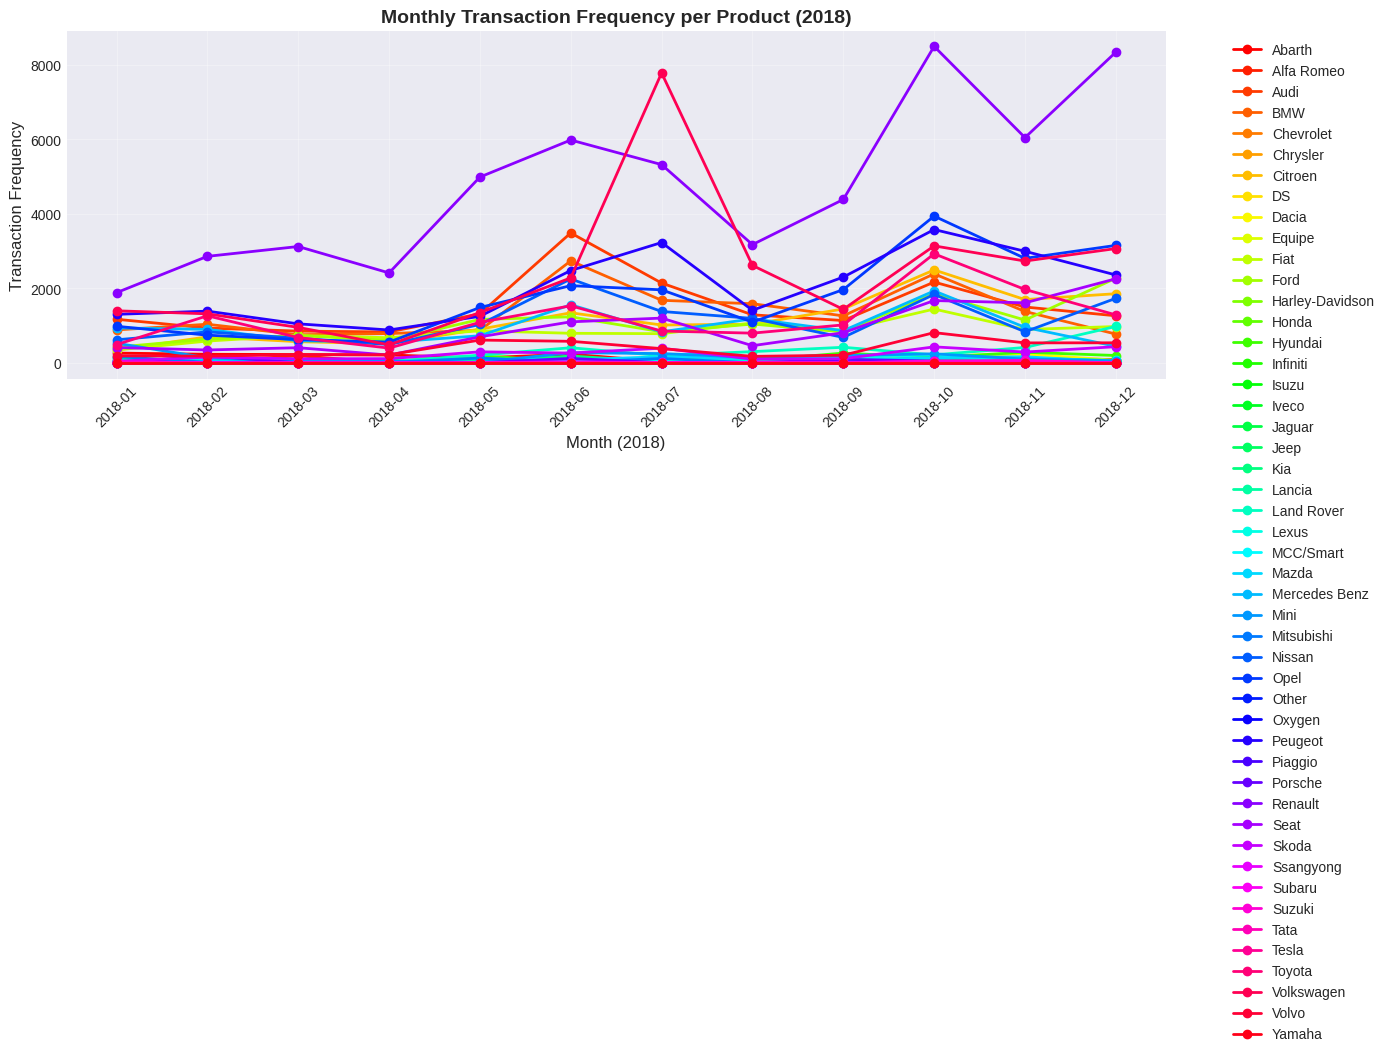

In [81]:
# Create plot for all products
fig, ax = plt.subplots(figsize=(14, 8))

# Use a colormap to generate many distinct colors (more than default 10)
# 'tab20' has 20 colors, 'tab20c' has 20 more, we can cycle through them
import matplotlib.cm as cm
n_products = len(all_products)
# Use a colormap that can generate many colors
colormap = cm.get_cmap('tab20')  # Has 20 distinct colors
if n_products > 20:
    # For more than 20 products, use a continuous colormap and sample evenly
    colormap = cm.get_cmap('hsv')  # Can generate infinite distinct colors

# Plot each product with distinct colors
for idx, product in enumerate(all_products):
    product_data = monthly_product_counts_complete[monthly_product_counts_complete['product_id'] == product]
    # Generate color from colormap, evenly spaced
    color = colormap(idx / max(n_products - 1, 1))  # Normalize to [0, 1]
    ax.plot(product_data['year_month'], product_data['transaction_count'], 
            marker='o', label=product, linewidth=2, markersize=6, color=color)

ax.set_xlabel('Month (2018)', fontsize=12)
ax.set_ylabel('Transaction Frequency', fontsize=12)
ax.set_title('Monthly Transaction Frequency per Product (2018)', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(FIGURES / 'monthly_product_frequency_2018.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Additional Exploratory Analysis

### 6.1 Overall Transaction Trends Over Time

In [ ]:
# Plot overall transaction volume over time
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(transactions_over_time.index.astype(str), transactions_over_time.values, 
        marker='o', linewidth=2, markersize=6)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Transactions', fontsize=12)
ax.set_title('Total Transactions Over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(FIGURES / 'transactions_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Transactional trends by year (side by side comparison)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Get unique years and sort them
years = sorted(df['year'].unique())
n_years = len(years)

# Create subplots: one per year, arranged horizontally
fig, axes = plt.subplots(1, n_years, figsize=(6*n_years, 5), sharey=True)

for idx, year in enumerate(years):
    ax = axes[idx]
    
    # Filter data for this year
    year_data = df[df['year'] == year]
    
    # Group by month and count transactions
    monthly_counts = year_data.groupby('month').size().sort_index()
    
    # Plot monthly trends
    ax.plot(monthly_counts.index, monthly_counts.values, 
            marker='o', linewidth=2, markersize=8)
    ax.set_xlabel('Month', fontsize=11)
    if idx == 0:
        ax.set_ylabel('Number of Transactions', fontsize=11)
    ax.set_title(f'Transactions in {year}', fontsize=12, fontweight='bold')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Add total count as text
    total_year = year_data.shape[0]
    ax.text(0.02, 0.98, f'Total: {total_year:,}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.suptitle('Yearly Transaction Trends Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES / 'yearly_transaction_trends.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Product sales histograms by year
# Group transactions by year and product
df['year'] = df['date'].dt.year
product_sales_by_year = df.groupby(['year', 'product_id']).size().reset_index(name='transaction_count')

# Get unique years
years = sorted(df['year'].unique())
n_years = len(years)

# Create 2x2 grid layout for better legibility
n_rows = 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 12))

# Flatten axes array for easier indexing
axes_flat = axes.flatten()

for idx, year in enumerate(years):
    if idx >= n_rows * n_cols:
        break  # Only plot up to 4 years in 2x2 grid
    
    ax = axes_flat[idx]
    
    # Filter data for this year
    year_data = product_sales_by_year[product_sales_by_year['year'] == year]
    
    # Sort by transaction count (descending) for better visualization
    year_data_sorted = year_data.sort_values('transaction_count', ascending=False)
    
    # Print top 5 and bottom 5 products for this year
    print(f"\n{'='*60}")
    print(f"Year {year} - Product Sales Summary")
    print(f"{'='*60}")
    print("\nTop 5 Products:")
    top_5 = year_data_sorted.head(5)
    for rank, (_, row) in enumerate(top_5.iterrows(), 1):
        print(f"  {rank}. {row['product_id']:20s} - {row['transaction_count']:6,} transactions")
    
    print("\nBottom 5 Products:")
    bottom_5 = year_data_sorted.tail(5)
    total_products = len(year_data_sorted)
    for idx, (_, row) in enumerate(bottom_5.iterrows()):
        rank = total_products - 4 + idx
        print(f"  {rank}. {row['product_id']:20s} - {row['transaction_count']:6,} transactions")
    
    # Create horizontal bar chart (histogram-like)
    # Each histogram has its own independent y-axis labels (no sharey!)
    ax.barh(range(len(year_data_sorted)), year_data_sorted['transaction_count'].values)
    ax.set_yticks(range(len(year_data_sorted)))
    ax.set_yticklabels(year_data_sorted['product_id'].values, fontsize=7)
    ax.set_xlabel('Number of Transactions', fontsize=10)
    ax.set_ylabel('Product', fontsize=10)
    ax.set_title(f'Product Sales in {year}', fontsize=11, fontweight='bold')
    ax.grid(True, axis='x', alpha=0.3)
    
    # Add total count as text
    total_year = year_data['transaction_count'].sum()
    ax.text(0.98, 0.02, f'Total: {total_year:,}', 
            transform=ax.transAxes, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# Hide unused subplots if there are fewer than 4 years
for idx in range(n_years, n_rows * n_cols):
    axes_flat[idx].axis('off')

plt.suptitle('Product Sales Distribution by Year', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(FIGURES / 'product_sales_by_year.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.2 Customer Activity Distribution

In [ ]:
# Histogram of transactions per customer
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(customer_activity.values, bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Number of Transactions per Customer', fontsize=12)
ax.set_ylabel('Number of Customers', fontsize=12)
ax.set_title('Distribution of Customer Activity', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add statistics
ax.axvline(customer_activity.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {customer_activity.median():.1f}')
ax.axvline(customer_activity.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {customer_activity.mean():.1f}')
ax.legend()

plt.tight_layout()
plt.savefig(FIGURES / 'customer_activity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Key Observations and Insights

Document findings that will inform modeling decisions.

In [ ]:
# Calculate key statistics for documentation
print("=== KEY OBSERVATIONS ===\n")

# Customer heterogeneity
print(f"\n1. CUSTOMER HETEROGENEITY:")
print(f"   - Transactions per customer - Mean: {customer_activity.mean():.2f}")
print(f"   - Transactions per customer - Median: {customer_activity.median():.2f}")
print(f"   - Transactions per customer - Std: {customer_activity.std():.2f}")
print(f"   - Coefficient of variation: {customer_activity.std() / customer_activity.mean():.2f}")
print(f"   - Top 10% of customers account for {customer_activity.nlargest(int(len(customer_activity) * 0.1)).sum() / customer_activity.sum():.1%} of transactions")

# Temporal coverage
print(f"\n2. TEMPORAL COVERAGE:")
print(f"   - Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"   - Total days: {(df['date'].max() - df['date'].min()).days}")
print(f"   - Months with data: {df['year_month'].nunique()}")

# Product distribution
print(f"\n3. PRODUCT DISTRIBUTION:")
print(f"   - Number of unique products: {df['product_id'].nunique()}")
print(f"   - Most popular product: {transactions_per_product.index[0]} ({transactions_per_product.iloc[0]:,} transactions)")
print(f"   - Least popular product: {transactions_per_product.index[-1]} ({transactions_per_product.iloc[-1]:,} transactions)")

# Seasonality check (preliminary)
print(f"\n4. SEASONALITY (Preliminary):")
monthly_2018 = df_2018.groupby(df_2018['date'].dt.month).size()
if len(monthly_2018) > 0:
    print(f"   - 2018 monthly transaction counts:")
    for month, count in monthly_2018.items():
        month_name = pd.Timestamp(2018, month, 1).strftime('%B')
        print(f"     {month_name}: {count:,}")
    # Check for seasonality pattern
    if monthly_2018.max() / monthly_2018.min() > 1.5:
        print(f"   - Significant variation detected (max/min ratio: {monthly_2018.max() / monthly_2018.min():.2f})")
    else:
        print(f"   - Relatively stable across months")

### Summary for Modeling

Based on the exploratory analysis:

1. **Data Quality**: Data quality was good overall, very little duplicates which were treated as errors and removed (alternative would've been to consider purchases with quanitity > 1 as having logged over mutiple lines but there were so little it did not matter). Some product_ids were found to be odd and were grouped into one "Other" category.
2. **Customer Heterogeneity**: Variance is high meaning we need a model where the variance scales stronger than the mean, first consideration of Poisson distribution is therefore not fit.
3. **Temporal Patterns**: We can observe in 2017 and 2018 that there are strong peaks of activity towards the middle and end of year (summer and beginning of Winter). This trend does not translate as cleanly in 2019 which seems to show more market stability with smaller variance. Very little data for 2020 with a sharp drop off in sales since the beginning of the year (understandable as it could be heavily justified by the social context at the time --Pandemic--)
4. **Product Dynamics**: 
Dominant products seem to keep up that dominance throughout the entirety of the year, sals in function of product seem to decrease exponentially from best selling to worst selling.
